In [1]:
import tensorflow as tf
import numpy as np
import os
import json
import nrrd
import matplotlib.pyplot as plt
import random
import utils
import time
import model_utils


### FIX PARAMETERS

These could be in a config file

In [2]:
with open(r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/dataInfo.json') as j:
     DATAJSON = json.loads(j.read())
        
IMAGEFOLDER=r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/images'
MASKFOLDER=r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/masks'
NUMOFTRAINDATAS=7500
NUMOFTESTDATAS=1500
BATCHLEN=5
BATCHPEREPOCH=NUMOFTRAINDATAS/BATCHLEN
PROPOSALCOUNT=20
ROISIZE=[5,5]
MASKROISIZE=[14,14]
CLASSDICT={0:'heart',1:'star'}



### DataGenerators



In [3]:
def batchgenerator_cnn(datafolder,jsonfile,batchlen,numofdatas=None,fromimage=0):
    if numofdatas is None:
        numofdatas=len(os.listdir(datafolder))
    while True:
        indices = np.arange(fromimage,numofdatas)
        np.random.shuffle(indices)
        for batchstart in range(0+fromimage,fromimage+numofdatas,batchlen):
            x_batch=np.zeros((batchlen,512,512),dtype=np.float32)      
            y_batch=np.zeros((batchlen,2),dtype=np.float32)      
            filenames=[]
            for num,i in enumerate(indices[batchstart:batchstart+batchlen]):
                filename=str(i).zfill(6)+'.nrrd'
                data, h_=nrrd.read(os.path.join(datafolder,filename))
                x_batch[num]=data
                y_batch[num]=jsonfile[filename]['label']
                filenames.append(filename)
            if len(filenames)!=batchlen:
                continue
            else:
                x_batch=np.expand_dims(x_batch,-1)
                yield x_batch, y_batch

In [4]:
def batchgenerator_maskrcnn(datafolder,maskfolder,jsonfile,batchlen,numofdatas=None,mode='Complextrain',fromimage=0):
    if numofdatas is None:
        numofdatas=len(os.listdir(datafolder))
    indices = np.arange(fromimage,numofdatas)
    np.random.shuffle(indices)
    for batchstart in range(0+fromimage,fromimage+numofdatas,batchlen):
        x_batch=np.zeros((batchlen,512,512),dtype=np.float32)  
        y_batch=np.zeros((batchlen,2),dtype=np.float32)        
        m_batch=np.zeros((batchlen,512,512),dtype=np.float32)      
        bb_batch=[]
        filenames=[]
        for num,i in enumerate(indices[batchstart:batchstart+batchlen]):
            filename=str(i).zfill(6)+'.nrrd'
            data, h_=nrrd.read(os.path.join(datafolder,filename))
            x_batch[num]=data
            y_batch[num]=jsonfile[filename]['label']
            bbox=jsonfile[filename]['bbox']
            bb_batch.append(np.asarray(bbox))
            filenames.append(filename)
            if mode == 'Masktrain':
                mask, h_=nrrd.read(os.path.join(maskfolder,filename))
                m_batch[num]=mask           
        if (np.sum(np.sum(np.sum(bb_batch)))==0): # we can't have a batch full of only BG images, cause the boxloss only takes FGs --> it would go to Nan in case of a full BG batch
            continue
        elif len(filenames)!=batchlen:
            continue
        else:
            x_batch=np.expand_dims(x_batch,-1)
            if mode=='RPNtrain':
                yield x_batch, bb_batch
            elif mode=='Headtrain':
                yield x_batch,y_batch,bb_batch
            elif mode=='Masktrain' or mode=='Complextrain':
                m_batch=np.expand_dims(m_batch,-1)
                yield x_batch,y_batch,bb_batch, m_batch, filenames

                

### CNN

In [6]:
input_=tf.keras.layers.Input((512,512,1))

x=tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(input_)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
#256

x=tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
#128


x=tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
#64

x=tf.keras.layers.Conv2D(256, (5, 5), activation='relu',padding='same')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
#32

featuremap=tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',name='featuremap')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(featuremap)
#16


x=tf.keras.layers.Flatten()(x)
output=tf.keras.layers.Dense(2,activation='sigmoid')(x) # a multiclass one-hot encoding miatt szükséges h az utolsó aktiváció sigmoid legyen
CNNFM=tf.keras.Model(input_,featuremap,name="CNN_fm")
CNN=tf.keras.Model(input_,output,name="CNN")



CNNFM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy())
CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5))

batchgen_cnn=batchgenerator_cnn(datafolder=IMAGEFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,numofdatas=NUMOFTRAINDATAS)
CNN.fit(batchgen_cnn,epochs=20,steps_per_epoch=BATCHPEREPOCH)

Epoch 1/20
1500/1500 [==============================] - 80s 53ms/step - loss: 0.7049 - binary_accuracy: 0.5053
Epoch 2/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.6771 - binary_accuracy: 0.5669
Epoch 3/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.2879 - binary_accuracy: 0.8701
Epoch 4/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0539 - binary_accuracy: 0.9831
Epoch 5/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0274 - binary_accuracy: 0.9911
Epoch 6/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0156 - binary_accuracy: 0.9961
Epoch 7/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0192 - binary_accuracy: 0.9944
Epoch 8/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0104 - binary_accuracy: 0.9969
Epoch 9/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.0120 - binary_accuracy: 0.9967
E

In [7]:
CNN.save('saved_models/fullbackbone_newdataset_7500.h5')
CNNFM.save('saved_models/featuremapmodelexample_newdataset_7500.h5')

In [9]:
cnnmodel=tf.keras.models.load_model('saved_models/fullbackbone_newdataset_7500.h5')
fmmodel=tf.keras.models.load_model('saved_models/featuremapmodelexample_newdataset_7500.h5')

In [10]:
featuremap=[layer for layer in cnnmodel.layers if layer.name=='featuremap']
featuremap=featuremap[0].output

In [11]:
FEATURESHAPE=featuremap.shape
FEATURESIZE=[featuremap.shape[1],featuremap.shape[2]]
FEATUREFILTER=featuremap.shape[-1]


### Generating anchors


In [12]:
ALLANCHORS=utils.generate_anchors(featuremap)

Num of generated anchors:	 5120


### RPN
#### Region Proposal Network

In [13]:
#RPN modell

initializer = tf.keras.initializers.GlorotNormal(seed=None)
input_= tf.keras.layers.Input(shape=[None, None, featuremap.shape[-1]], name="rpn_INPUT")

shared = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', strides=1, name='rpn_conv_shared',kernel_initializer=initializer)(input_)
x = tf.keras.layers.Conv2D(5*2 , (1, 1), padding='valid', activation='linear',name='rpn_class_raw',kernel_initializer=initializer)(shared) 

rpn_class_logits = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)
rpn_probs = tf.keras.layers.Activation("softmax", name="rpn_class_xxx")(rpn_class_logits) # --> BG/FG

# Bounding box refinement. [batch, H, W, depth]
x = tf.keras.layers.Conv2D(5*4, (1, 1), padding="valid", activation='linear', name='rpn_bbox_pred',kernel_initializer=initializer)(shared) 

# Reshape to [batch, anchors, 4]
rpn_bbox = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)
outputs = [rpn_class_logits, rpn_probs, rpn_bbox]
RPN = tf.keras.models.Model(input_, outputs, name="RPN")

#rpn_optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9,clipnorm=5.0)
#rpn_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [14]:
def smooth_l1(y_true, y_pred):
    # Take absolute difference
    x = tf.abs(y_true - y_pred)
    # Find indices of values less than 1
    mask = tf.cast(tf.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


def rpn_loss(rpn_logits,rpn_deltas, gt_labels,gt_deltas , indices, batchlen):
    
    '''
    rpn_logits,rpn_deltas: the predicted logits/deltas to all the anchors
    gt_labels,gt_deltas: the correct labels and deltas to the chosen training anchors
    indices: the indices of the chosen training anchors
    '''

    predicted_classes = tf.gather_nd(rpn_logits, indices)
    foregroundindices=indices[gt_labels.astype('bool')]#labels: 0:BG  1:FG
    predicted_deltas=tf.cast(tf.gather_nd(rpn_deltas, foregroundindices),tf.float32) #only the foreground anchors contribute to the box loss
    gt_deltas=tf.cast(tf.gather_nd(gt_deltas, foregroundindices),tf.float32)

    # Cross entropy loss

    lf=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    classloss = lf(gt_labels,predicted_classes)
    classloss=tf.reduce_mean(classloss)
    
    deltaloss=smooth_l1(gt_deltas,predicted_deltas)
    deltaloss=tf.reduce_mean(deltaloss)
    
    return classloss,deltaloss


In [15]:
def create_rpn_trainstep(rpnmodel,fmmodel):
    #@tf.function(experimental_relax_shapes=True)
    def rpn_trainstep(images, gt_box, batchlen, rpn_optimizer):
        with tf.GradientTape() as gradientT:
            featuremaps=fmmodel(images)
            logits,probs,deltas = rpnmodel(featuremaps)    #Itt kapjuk meg az RPN kimeneteket
            indices,gt_deltas,gt_labels=utils.indices_deltas_labels(gt_box,ALLANCHORS,batchlen,PROPOSALCOUNT,mode='pixelwise')
            rpn_loss_class,rpn_loss_delta = rpn_loss(logits, deltas, gt_labels, gt_deltas, indices, batchlen)                
            rpn_loss_w=rpn_loss_class+rpn_loss_delta
        gradients_of_rpn = gradientT.gradient(rpn_loss_w, rpnmodel.trainable_variables)
        rpn_optimizer.apply_gradients(zip(gradients_of_rpn, rpnmodel.trainable_variables))
        return rpn_loss_w,rpn_loss_class,rpn_loss_delta
    return rpn_trainstep

In [16]:
def train_rpn(rpnmodell, fmmodel,datafolder,maskfolder,jsonfile,batchlen, epochs,numofdatas=None,rpn_optimizer=None):
    if numofdatas is None:
        numofdatas=len(os.listdir(datafolder))
    if rpn_optimizer is None:
        rpn_optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9,clipnorm=5.0)
    trainstep=create_rpn_trainstep(rpnmodell,fmmodel)
    for epoch in range(epochs):
        start = time.time()
        losses=[]
        losses_c=[]
        losses_d=[]
        batchgen=batchgenerator_maskrcnn(datafolder,maskfolder,jsonfile,batchlen,numofdatas=numofdatas,mode='RPNtrain')
        for num,image_batch in enumerate(batchgen):
            x,bb=image_batch
            l,lc,ld=trainstep(x,bb,batchlen,rpn_optimizer)
            losses.append(l)
            losses_c.append(lc)
            losses_d.append(ld)

        end = time.time()
        print(round(end-start),'sec. \t',epoch,'.epoch:\t loss(sum,c,bb):\t', np.mean(losses),np.mean(losses_c),np.mean(losses_d))
        


In [18]:
train_rpn(rpnmodell=RPN,fmmodel=fmmodel,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=5,epochs=30,numofdatas=NUMOFTRAINDATAS) 


210 sec. 	 0 .epoch:	 loss(sum,c,bb):	 3.4964135 0.28304636 3.2133672
210 sec. 	 1 .epoch:	 loss(sum,c,bb):	 2.5844853 0.15288578 2.4315996
210 sec. 	 2 .epoch:	 loss(sum,c,bb):	 2.2150414 0.0997375 2.115304
209 sec. 	 3 .epoch:	 loss(sum,c,bb):	 2.0049264 0.07285361 1.9320729
209 sec. 	 4 .epoch:	 loss(sum,c,bb):	 1.8609391 0.0566864 1.8042526
210 sec. 	 5 .epoch:	 loss(sum,c,bb):	 1.7553186 0.046707816 1.7086111
209 sec. 	 6 .epoch:	 loss(sum,c,bb):	 1.6759609 0.039574638 1.6363863
209 sec. 	 7 .epoch:	 loss(sum,c,bb):	 1.5969372 0.03472428 1.562213
209 sec. 	 8 .epoch:	 loss(sum,c,bb):	 1.540519 0.030360697 1.5101584
209 sec. 	 9 .epoch:	 loss(sum,c,bb):	 1.4891181 0.027942957 1.461175
209 sec. 	 10 .epoch:	 loss(sum,c,bb):	 1.4583163 0.025340129 1.4329762
209 sec. 	 11 .epoch:	 loss(sum,c,bb):	 1.4168149 0.0231502 1.3936645
209 sec. 	 12 .epoch:	 loss(sum,c,bb):	 1.3733115 0.021374376 1.3519372
209 sec. 	 13 .epoch:	 loss(sum,c,bb):	 1.3352929 0.019652577 1.3156403
209 sec. 	 14 .e

In [19]:
RPN.save('saved_models/rpn_newdataset_7500.h5')

In [20]:
rpnmodel=tf.keras.models.load_model('saved_models/rpn_newdataset_7500.h5')


### RPN predikciók vizualizálása

### CLASSHEAD & BOX REFINEMENT



In [21]:
#small class head
input_=tf.keras.layers.Input((PROPOSALCOUNT,ROISIZE[0],ROISIZE[1],FEATUREFILTER))

x=tf.keras.layers.Conv2D(kernel_size=(1,1),padding='valid',activation='relu',filters=FEATUREFILTER)(input_)
x=tf.debugging.check_numerics(x, 'x has nan')
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2D(kernel_size=(1,1),padding='valid',activation='relu',filters=FEATUREFILTER)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

flatten=tf.keras.layers.Flatten()(x)

beforeclass=tf.keras.layers.Dense(PROPOSALCOUNT*3,name='beforeclasspred')(flatten)#3: numofclasses + 1 for background
beforeclass=tf.debugging.check_numerics(beforeclass, 'beforeclass has nan')

class_logits = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], PROPOSALCOUNT,3]),name='classpred')(beforeclass)
class_probs= tf.keras.layers.Activation("softmax", name="classhead_class")(class_logits) # --> BG/FG



beforebox=tf.keras.layers.Dense(3*4*PROPOSALCOUNT,activation='linear',name='beforeboxpred')(flatten) # 3 is the num of classes + 1 for background
bboxpred = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0],PROPOSALCOUNT, 3, 4]),name='boxrefinement')(beforebox) # for every roi for every class we predict dx,dy,dw,dh
outputs=[class_logits,class_probs,bboxpred]
CLASSHEAD=tf.keras.Model(input_,outputs,name="classhead")


In [24]:
def ch_loss(ch_logits, ch_deltas, gt_labels, gt_deltas, indices):

    predicted_classes = tf.gather_nd(ch_logits, indices)
    foregroundindices=tf.where(gt_labels<2)#where the label is 2 it means it is a backrground box -> we filter these out   

    classlabels=tf.cast(tf.gather_nd(gt_labels,foregroundindices),tf.int32) #the boxrefinement predicted deltas to each class; we need the proper classes to filter out the proper deltas
    idxs=tf.range(classlabels.shape)
    classlabels=tf.stack((idxs,classlabels),axis=1)# pred_deltas shape: (proposalcount,classes,4) -> we want to filter from axis1 -> easiest is to have 0 dimension ready with range
    
    pd=tf.gather_nd(ch_deltas,indices)# filter out proposed box deltas from all deltas
    gd=tf.gather_nd(gt_deltas,indices)# filter out proposed box deltas from all deltas
    
    predicted_deltas=tf.cast(tf.gather_nd(pd, foregroundindices),tf.float32) #only positive boxes contribute to the box refinement loss
    predicted_deltas=tf.cast(tf.gather_nd(predicted_deltas, classlabels),tf.float32)#only the proper classes box contribute to the box refinement loss
    gtdeltas=tf.cast(tf.gather_nd(gd, foregroundindices),tf.float32)
    

    not_empty_images=tf.where(tf.math.logical_not(tf.reduce_all(tf.equal(gt_labels,2),axis=-1)))
    not_empty_gts=tf.gather(gt_labels,not_empty_images,axis=0) #we dont want only background images in the classloss, that would inbalance the dataset
    not_empty_preds=tf.gather(predicted_classes,not_empty_images,axis=0)
    
    # Cross entropy loss
    lf=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    classloss = lf(not_empty_gts,not_empty_preds)
    classloss=tf.reduce_sum(classloss)
    
    deltaloss=smooth_l1(gtdeltas,predicted_deltas)
    deltaloss=tf.reduce_sum(deltaloss)

    
    return classloss,deltaloss


def smooth_l1(y_true, y_pred):
    # Take absolute difference
    x = tf.abs(y_true - y_pred)
    # Find indices of values less than 1
    mask = tf.cast(tf.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


In [22]:
def train_classhead(classheadmodel,rpnmodel, fmmodel,numofdatas,datafolder,maskfolder,jsonfile,batchlen, epochs,ch_optimizer=None):
    if ch_optimizer is None:
        #ch_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=0.5,clipnorm=1)
        ch_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,clipnorm=5.0)
    trainstep=create_ch_trainstep(classheadmodel,rpnmodel,fmmodel)
    for epoch in range(epochs):
        losses_c=[]
        losses_d=[]
        start = time.time()
        batchgen=batchgenerator_maskrcnn(datafolder,maskfolder,jsonfile,batchlen,numofdatas,mode='Headtrain',fromimage=5)
        for num,image_batch in enumerate(batchgen):
            x,y,bb=image_batch
            classloss,deltaloss=trainstep(x,y,bb,batchlen,ch_optimizer)
            losses_c.append(classloss)
            losses_d.append(deltaloss)
        end = time.time()
        print(round(end-start),'sec. \t',epoch,'.epoch: \t loss(c,bb):\t',np.mean(losses_c),np.mean(losses_d))
        
        


In [23]:
def create_ch_trainstep(classheadmodel,rpnmodel,fmmodel):
    #@tf.function(experimental_relax_shapes=True)
    def ch_trainstep(images,labels, gt_box, batchlen, ch_optimizer):
        with tf.GradientTape() as gradientT:
            featuremaps=fmmodel(images)
            rpn_logits,rpn_probs,rpn_boxes=rpnmodel(featuremaps)
            proposals=utils.get_proposals(rpn_probs,rpn_boxes,ALLANCHORS)            
            aligned_rois=utils.roi_align(featuremaps,proposals,ROISIZE)
            ch_logits,ch_probs,ch_deltas= classheadmodel(aligned_rois)  
            indices,gt_deltas,gt_labels=utils.head_indices_deltas_labels(gt_box, labels, proposals, batchlen=batchlen, train_set_size=6)
            ch_classloss,ch_deltaloss = ch_loss(ch_logits, ch_deltas, gt_labels, gt_deltas, indices)   
            ch_loss_w=ch_classloss+ch_deltaloss
        gradients_of_classhead = gradientT.gradient(ch_loss_w, classheadmodel.trainable_variables)
        ch_optimizer.apply_gradients(zip(gradients_of_classhead, classheadmodel.trainable_variables))
        return ch_classloss,ch_deltaloss,
    return ch_trainstep


        
    

In [25]:
train_classhead(classheadmodel=CLASSHEAD,rpnmodel=rpnmodel,fmmodel=fmmodel,numofdatas=NUMOFTRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=5,epochs=20) 

164 sec. 	 0 .epoch: 	 loss(c,bb):	 0.56610227 180.04922
163 sec. 	 1 .epoch: 	 loss(c,bb):	 0.32819816 130.96059
163 sec. 	 2 .epoch: 	 loss(c,bb):	 0.27316403 108.22844
163 sec. 	 3 .epoch: 	 loss(c,bb):	 0.24680023 94.404106
163 sec. 	 4 .epoch: 	 loss(c,bb):	 0.2272216 83.32413
163 sec. 	 5 .epoch: 	 loss(c,bb):	 0.21119611 73.92056
163 sec. 	 6 .epoch: 	 loss(c,bb):	 0.19745049 65.902084
163 sec. 	 7 .epoch: 	 loss(c,bb):	 0.19053565 60.0827
163 sec. 	 8 .epoch: 	 loss(c,bb):	 0.18368052 55.32722
163 sec. 	 9 .epoch: 	 loss(c,bb):	 0.17657752 50.5625
163 sec. 	 10 .epoch: 	 loss(c,bb):	 0.16952983 46.457882
163 sec. 	 11 .epoch: 	 loss(c,bb):	 0.16616085 42.92064
163 sec. 	 12 .epoch: 	 loss(c,bb):	 0.15913226 39.63527
163 sec. 	 13 .epoch: 	 loss(c,bb):	 0.1551771 37.026024
163 sec. 	 14 .epoch: 	 loss(c,bb):	 0.152185 33.954903
164 sec. 	 15 .epoch: 	 loss(c,bb):	 0.14759502 31.899696
163 sec. 	 16 .epoch: 	 loss(c,bb):	 0.1442782 29.858461
163 sec. 	 17 .epoch: 	 loss(c,bb):	 0

In [26]:
CLASSHEAD.save('saved_models/classhead_newdataset_7500.h5')

In [27]:
classheadmodel=tf.keras.models.load_model('saved_models/classhead_newdataset_7500.h5')

### MASKHEAD 

In [29]:
# Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
input_=tf.keras.layers.Input((PROPOSALCOUNT,MASKROISIZE[0],MASKROISIZE[1],FEATUREFILTER))

x=tf.keras.layers.Conv2D(kernel_size=(1,1),padding='same',activation='relu',filters=FEATUREFILTER/2)(input_)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.Conv2D(kernel_size=(3,3),padding='same',activation='relu',filters=FEATUREFILTER/2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)


x=tf.keras.layers.Conv2D(kernel_size=(3,3),padding='same',activation='relu',filters=FEATUREFILTER/2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)

x=tf.keras.layers.TimeDistributed(tf.keras.layers.UpSampling2D(size=(2,2)))(x)
x=tf.keras.layers.ReLU()(x)
pred_mask=tf.keras.layers.Conv2D(kernel_size=(1,1),padding='same',activation='sigmoid',filters=2)(x) #2 filters, as we predict a mask for each class 

MASKHEAD=tf.keras.Model(input_,pred_mask,name="maskhead")


In [32]:
def mask_loss(pred_mask,gt_mask,gt_labels,indices):
    
    foregroundindices=tf.where(gt_labels<2)
    classlabels=tf.cast(tf.gather_nd(gt_labels,foregroundindices),tf.int32)
    idxs=tf.range(classlabels.shape)
    classlabels=tf.stack((idxs,classlabels),axis=1)
    
    pm=tf.cast(tf.gather_nd(pred_mask,indices),tf.float32)
    pm=tf.gather_nd(pm,foregroundindices)
    pm=tf.transpose(pm,[0,3,1,2])
    predicted_masks=tf.gather_nd(pm, classlabels)
    predicted_masks=tf.expand_dims(predicted_masks, axis=-1)

    
    gm=tf.cast(tf.gather_nd(gt_mask,indices),tf.float32)
    gt_masks=tf.cast(tf.gather_nd(gm,foregroundindices),tf.float32)
    gt_max=tf.reduce_max(gt_masks)
    gt_masks=tf.math.divide(gt_masks,gt_max) #we need a binary mask

    lf=tf.keras.losses.binary_crossentropy(gt_masks,predicted_masks)
    loss=tf.reduce_mean(lf) 
    return loss
    
    

In [30]:
def create_mask_trainstep(maskheadmodel,rpnmodel,fmmodel):
    #@tf.function(experimental_relax_shapes=True)
    def mask_trainstep(images,labels, gt_box, masks, batchlen, mask_optimizer):
        with tf.GradientTape() as gradientT:
            featuremaps=fmmodel(images)
            rpn_logits,rpn_probs,rpn_boxes=rpnmodel(featuremaps)
            proposals=utils.get_proposals(rpn_probs,rpn_boxes,ALLANCHORS)            
            indices,gt_deltas,gt_labels=utils.head_indices_deltas_labels(gt_box, labels, proposals, batchlen=batchlen, train_set_size=6)
            fm_rois,mask_rois=utils.mask_roi_align(featuremaps,masks,proposals,MASKROISIZE)
            predicted_masks=maskheadmodel(fm_rois)
            maskloss=mask_loss(predicted_masks,mask_rois,gt_labels,indices)
        gradients_of_maskhead = gradientT.gradient(maskloss, maskheadmodel.trainable_variables)
        mask_optimizer.apply_gradients(zip(gradients_of_maskhead, maskheadmodel.trainable_variables))
        return maskloss
    return mask_trainstep


        
    

In [31]:
def train_maskhead(maskheadmodel,rpnmodel, fmmodel,numofdatas,datafolder,maskfolder,jsonfile,batchlen, epochs,mask_optimizer=None):
    if mask_optimizer is None:
        mask_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=0.5,clipnorm=1)
        #mask_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,clipnorm=5.0)
    trainstep=create_mask_trainstep(maskheadmodel,rpnmodel,fmmodel)
    for epoch in range(epochs):
        losses_m=[]
        start = time.time()
        batchgen=batchgenerator_maskrcnn(datafolder,maskfolder,jsonfile,batchlen,numofdatas,mode='Masktrain',fromimage=0)
        for num,image_batch in enumerate(batchgen):
            x,y,bb,m,fnames=image_batch
            maskloss=trainstep(x,y,bb,m,batchlen,mask_optimizer)
            losses_m.append(maskloss)
        end = time.time()
        print(round(end-start),'sec. \t',epoch,'.epoch: \t loss:\t',np.mean(losses_m))
        
        


In [33]:
train_maskhead(maskheadmodel=MASKHEAD,rpnmodel=rpnmodel,fmmodel=fmmodel,numofdatas=NUMOFTRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=5,epochs=15) 

251 sec. 	 0 .epoch: 	 loss:	 0.3189015
251 sec. 	 1 .epoch: 	 loss:	 0.25681022
254 sec. 	 2 .epoch: 	 loss:	 0.24083513
251 sec. 	 3 .epoch: 	 loss:	 0.23274496
251 sec. 	 4 .epoch: 	 loss:	 0.22543685
251 sec. 	 5 .epoch: 	 loss:	 0.2196407
251 sec. 	 6 .epoch: 	 loss:	 0.21513271
251 sec. 	 7 .epoch: 	 loss:	 0.21175809
251 sec. 	 8 .epoch: 	 loss:	 0.20821461
251 sec. 	 9 .epoch: 	 loss:	 0.20602901
251 sec. 	 10 .epoch: 	 loss:	 0.203437
251 sec. 	 11 .epoch: 	 loss:	 0.20207511
251 sec. 	 12 .epoch: 	 loss:	 0.20013016
251 sec. 	 13 .epoch: 	 loss:	 nan
251 sec. 	 14 .epoch: 	 loss:	 0.19672851


In [34]:
MASKHEAD.save('saved_models/maskhead_newdataset_7500.h5')

In [35]:
maskheadmodel=tf.keras.models.load_model('saved_models/maskhead_newdataset_7500.h5')

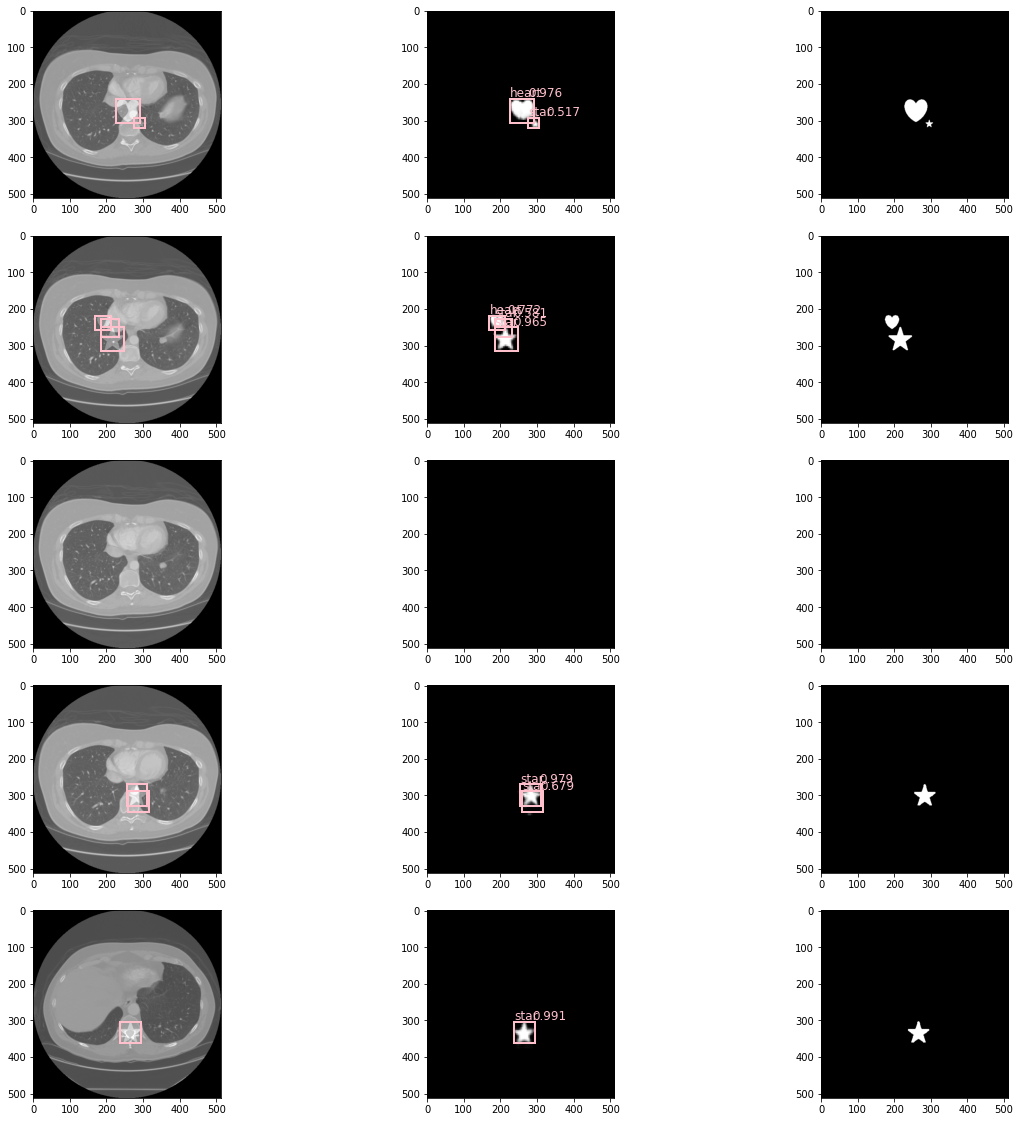

In [51]:
image_batch,masks_batch,bbox_batch,label_batch=utils.read_batch(IMAGEFOLDER,MASKFOLDER,DATAJSON,batchlen=BATCHLEN,start=14)
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)

In [52]:
def create_complex_trainstep(fmmodel,rpnmodel,classheadmodel,maskheadmodel):
    #@tf.function(experimental_relax_shapes=True)
    def complex_trainstep(images,gt_labels, gt_box,masks,allanchors, batchlen,proposalcount,roisize,maskroisize, complex_optimizer):
        with tf.GradientTape() as gradientT:
            
            featuremaps=fmmodel(images)
            #RPN
            rpn_logits,rpn_probs,rpn_deltas = rpnmodel(featuremaps)    #Itt kapjuk meg az RPN kimeneteket
            rpn_indices,rpn_gt_deltas,rpn_gt_labels=utils.indices_deltas_labels(gt_box,allanchors,batchlen,proposalcount,mode='pixelwise')
            rpn_loss_class,rpn_loss_delta = rpn_loss(rpn_logits, rpn_deltas, rpn_gt_labels, rpn_gt_deltas, rpn_indices, batchlen)                
            rpn_loss_w=rpn_loss_class+rpn_loss_delta
            
            #CH-BoxRefinement
            proposals=utils.get_proposals(rpn_probs,rpn_deltas,allanchors)            
            ch_indices,ch_gt_deltas,ch_gt_labels=utils.head_indices_deltas_labels(gt_box, gt_labels, proposals, batchlen=batchlen, train_set_size=6)
            aligned_rois=utils.roi_align(featuremaps,proposals,roisize)
            ch_logits,ch_probs,ch_deltas= classheadmodel(aligned_rois)  
            ch_classloss,ch_deltaloss = ch_loss(ch_logits, ch_deltas, ch_gt_labels, ch_gt_deltas, ch_indices)   
            ch_loss_w=ch_classloss+ch_deltaloss
            
            #Maskhead
            fm_rois,mask_rois=utils.mask_roi_align(featuremaps,masks,proposals,maskroisize)
            predicted_masks=maskheadmodel(fm_rois)
            maskloss=mask_loss(predicted_masks,mask_rois,gt_labels,ch_indices)
            
            #Complex loss and variables
            complexloss=rpn_loss_w+ch_loss_w+maskloss
            complextrainables=fmmodel.trainable_variables+rpnmodel.trainable_variables+classheadmodel.trainable_variables+maskheadmodel.trainable_variables
        
        gradients = gradientT.gradient(complexloss, complextrainables)
        complex_optimizer.apply_gradients(zip(gradients, complextrainables))
        return rpn_loss_w,ch_loss_w,maskloss
    return complex_trainstep



In [53]:
def train_complex(fmmodel,rpnmodel,classheadmodel,maskheadmodel,allanchors,proposalcount,roisize,maskroisize,numofdatas,datafolder,maskfolder,jsonfile,batchlen, epochs,trainfromimage=0,complex_optimizer=None):
    if complex_optimizer is None:
        complex_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=0.5,clipnorm=1)
        #mask_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,clipnorm=5.0)
    trainstep=create_complex_trainstep(fmmodel,rpnmodel,classheadmodel,maskheadmodel)
    for epoch in range(epochs):
        rpnlosses=[]
        chlosses=[]
        masklosses=[]
        
        start = time.time()
        batchgen=batchgenerator_maskrcnn(datafolder,maskfolder,jsonfile,batchlen,numofdatas,mode='Complextrain',fromimage=trainfromimage)
        for num,image_batch in enumerate(batchgen):
            x,y,bb,m,fnames=image_batch
            rpnloss,chloss,maskloss=trainstep(x,y,bb,m,allanchors,batchlen,proposalcount,roisize,maskroisize,complex_optimizer)
            
            rpnlosses.append(rpnloss)
            chlosses.append(chloss)
            masklosses.append(maskloss)

        end = time.time()
        print(round(end-start),'sec. \t',epoch,'.epoch: \t rpn loss:',np.mean(rpnlosses),'\tch loss:',np.mean(chlosses),'\tmask loss:',np.mean(masklosses))
        
        

In [57]:
train_complex(fmmodel=fmmodel,rpnmodel=rpnmodel,classheadmodel=classheadmodel,maskheadmodel=maskheadmodel,\
                          allanchors=ALLANCHORS,proposalcount=PROPOSALCOUNT, roisize=ROISIZE,maskroisize=MASKROISIZE,\
                          numofdatas=NUMOFTRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=5) 

391 sec. 	 0 .epoch: 	 rpn loss: 0.6948695 	ch loss: 71.66231 	mask loss: 0.14389412
390 sec. 	 1 .epoch: 	 rpn loss: 0.36085898 	ch loss: 52.613148 	mask loss: 0.13448706
389 sec. 	 2 .epoch: 	 rpn loss: 0.25229156 	ch loss: 41.01291 	mask loss: 0.12922426
388 sec. 	 3 .epoch: 	 rpn loss: 0.1922903 	ch loss: 31.49532 	mask loss: 0.12586598
388 sec. 	 4 .epoch: 	 rpn loss: 0.15423757 	ch loss: 26.75755 	mask loss: 0.12355985


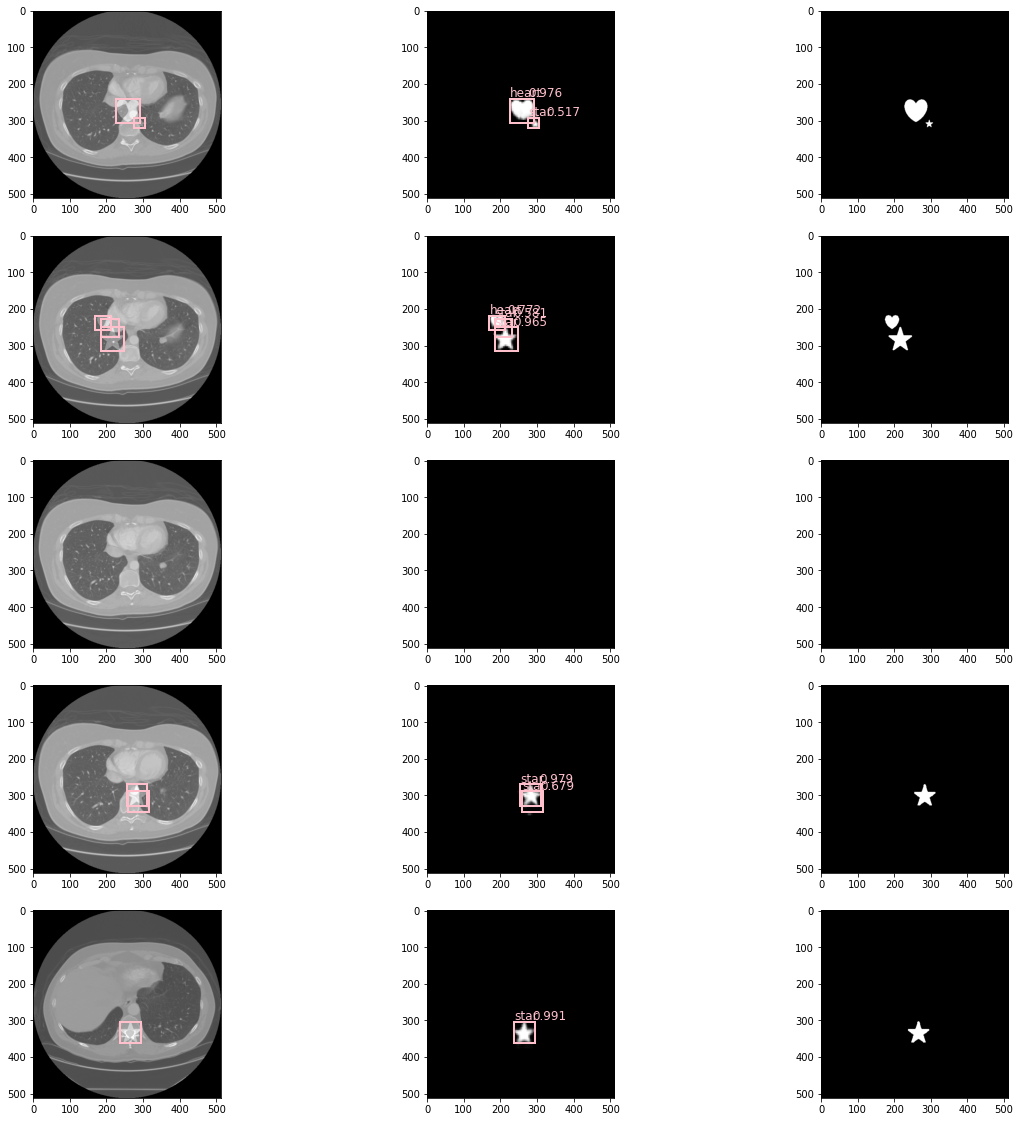

In [51]:
image_batch,masks_batch,bbox_batch,label_batch=utils.read_batch(IMAGEFOLDER,MASKFOLDER,DATAJSON,batchlen=BATCHLEN,start=14)
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)